In [1]:
!pip install opencv-python


In [2]:
!pip install deepface

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 21ms/step


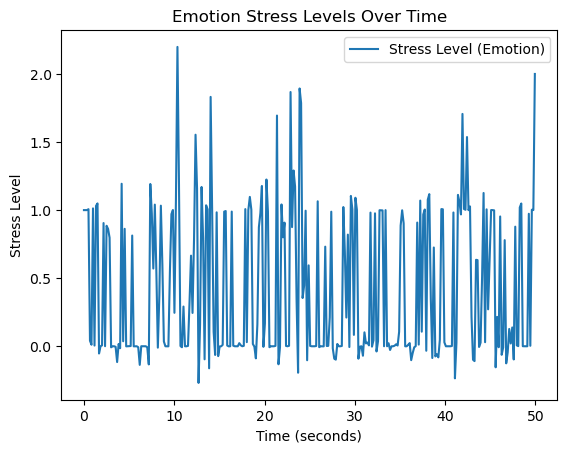

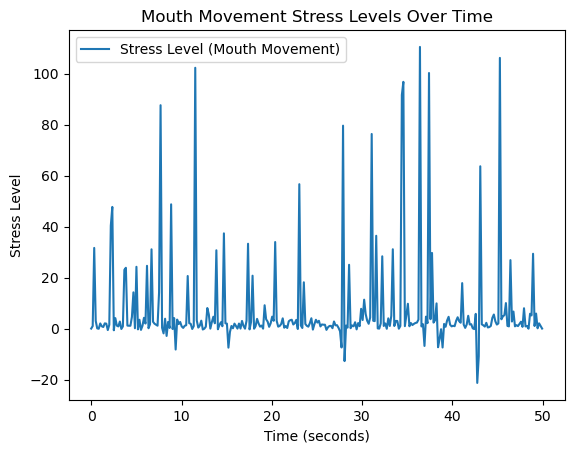

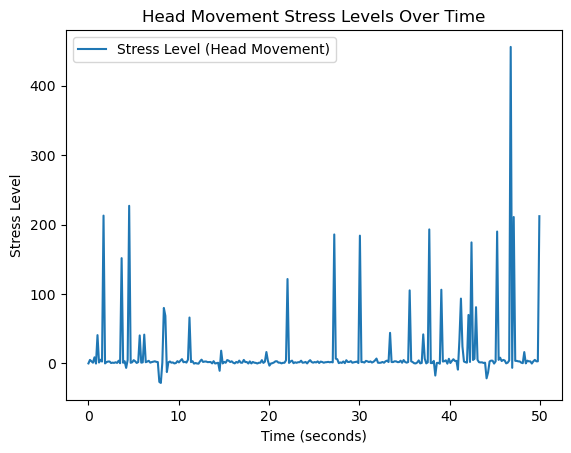

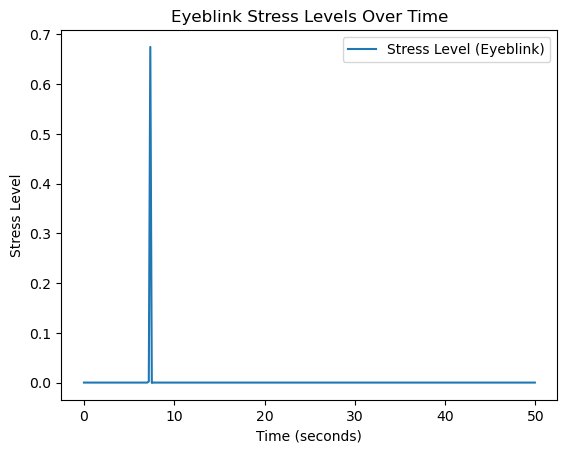

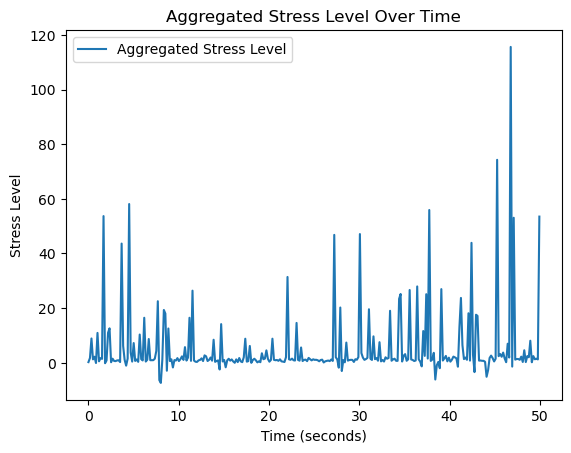

In [4]:
import cv2
from deepface import DeepFace
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Load the pre-trained emotion detection model
model = DeepFace.build_model("Emotion")

# Define emotion labels
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Load face cascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')  

mouth_cascade = cv2.CascadeClassifier(r"C:\Users\driss\OneDrive\Bureau\test.AX\mouth.xml")

eye_cascade = cv2.CascadeClassifier(r"C:\Users\driss\OneDrive\Bureau\test.AX\haarcascade_eye.xml")

if eye_cascade.empty():
    print("Error: Unable to load the eye cascade classifier.")

if mouth_cascade.empty():
    print("Error: Unable to load the mouth cascade classifier.")

# Path to the input video file
video_path = "C:/Users/driss/OneDrive/Bureau/test.AX/The Perfect Introduction _ Elevator Pitch.mp4" 

# Open the video file
cap = cv2.VideoCapture(video_path)

# Initialize variables
prev_mouth_x = None
prev_face_x = None
time_points = []
stress_levels_emotion = []
stress_levels_mouth = []
stress_levels_head = []
overall_stress_values = [] 

eye_state_prev = None
stress_levels_eye = []

prev_shoulder_y = None
stress_levels_shoulder = []

# Initialize weights for each stress factor
weight_emotion = 0.25
weight_mouth = 0.25
weight_head = 0.25
weight_eye = 0.25



while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Check if the video has ended
    if not ret:
        break

    # Convert frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Calculate stress level based on emotions
    stress_level_emotion = 0
    for (x, y, w, h) in faces:
        # Extract the face ROI (Region of Interest)
        face_roi = gray_frame[y:y + h, x:x + w]

        # Resize the face ROI to match the input shape of the model
        resized_face = cv2.resize(face_roi, (48, 48), interpolation=cv2.INTER_AREA)

        # Normalize the resized face image
        normalized_face = resized_face / 255.0

        # Reshape the image to match the input shape of the model
        reshaped_face = normalized_face.reshape(1, 48, 48, 1)

        # Predict emotions using the pre-trained model
        preds = model.predict(reshaped_face)[0]
        emotion_idx = preds.argmax()
        emotion = emotion_labels[emotion_idx]

        # Increase stress level for certain emotions (e.g., anger, fear)
        if emotion in ['angry', 'fear']:
            stress_level_emotion += 1

    # Detect mouth in the frame
    mouths = mouth_cascade.detectMultiScale(gray_frame, scaleFactor=1.8, minNeighbors=15, minSize=(30, 30))

    # Calculate stress level based on mouth movement
    if len(mouths) > 0:
        # Get the x-coordinate of the first detected mouth
        x, _, w, _ = mouths[0]

        # Calculate horizontal movement (change in x-coordinate)
        if prev_mouth_x is not None:
            movement = abs(x - prev_mouth_x)
            stress_level_mouth = movement
        else:
            stress_level_mouth = 0

        # Update previous mouth x-coordinate for the next frame
        prev_mouth_x = x

    else:
        # If no mouth detected, set stress level to 0
        stress_level_mouth = 0

    # Calculate stress level based on head movement
    stress_level_head = 0
    if len(faces) > 0:
        # Get the x-coordinate of the first detected face
        x, _, w, _ = faces[0]

        # Calculate horizontal movement (change in x-coordinate)
        if prev_face_x is not None:
            movement = abs(x - prev_face_x)
            stress_level_head = movement
        else:
            stress_level_head = 0

        # Update previous face x-coordinate for the next frame
        prev_face_x = x

    

    # Detect eyes in the frame
    eyes = eye_cascade.detectMultiScale(gray_frame)
    if len(eyes) == 2:
        x1, y1, w1, h1 = eyes[0]
        x2, y2, w2, h2 = eyes[1]
        eye_height_avg = (h1 + h2) / 2
        eye_ratio = (y2 - y1) / eye_height_avg
    else:
        eye_ratio = 0  # Pas assez d'yeux détectés

    blink_threshold = 0.2  # Seuil pour le ratio de fermeture des yeux
    stress_level_eye = 0

    if eye_ratio < blink_threshold and eye_state_prev == 'open':
        # Clignement détecté
        stress_level_eye += 1
        eye_state_prev = 'closed'
    elif eye_ratio >= blink_threshold:
        eye_state_prev = 'open'
    
    
    # Calculate overall stress based on different factors
    overall_stress = (
        weight_emotion * stress_level_emotion +
        weight_mouth * stress_level_mouth +
        weight_head * stress_level_head +
        weight_eye * stress_level_eye
    )

    # Append data for plotting
    time_points.append(cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0)  # Convert time to seconds
    stress_levels_emotion.append(stress_level_emotion)
    stress_levels_mouth.append(stress_level_mouth)
    stress_levels_head.append(stress_level_head)
    stress_levels_eye.append(stress_level_eye)
    overall_stress_values.append(overall_stress)
    # Display the resulting frame
    cv2.imshow('Stress Detection in Video', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


# Release the capture and close all windows
cap.release()
cv2.destroyAllWindows()

# Interpolate the data for smoother curves
spl_emotion = make_interp_spline(time_points, stress_levels_emotion, k=3)
spl_mouth = make_interp_spline(time_points, stress_levels_mouth, k=3)
spl_head = make_interp_spline(time_points, stress_levels_head, k=3)
spl_eye = make_interp_spline(time_points, stress_levels_eye, k=3) 


aggregated_stress = np.array(overall_stress_values) 

# Interpolate aggregated stress to match the number of points in time_points_smooth
spl_aggregated_stress = make_interp_spline(time_points, aggregated_stress, k=3)









time_points_smooth = np.linspace(min(time_points), max(time_points), 300)
stress_levels_emotion_smooth = spl_emotion(time_points_smooth)
stress_levels_mouth_smooth = spl_mouth(time_points_smooth)
stress_levels_head_smooth = spl_head(time_points_smooth)
stress_levels_eye_smooth = spl_eye(time_points_smooth)
aggregated_stress_interpolated = spl_aggregated_stress(time_points_smooth)

# Plot the stress levels for emotions over time
plt.plot(time_points_smooth, stress_levels_emotion_smooth, label='Stress Level (Emotion)')
plt.xlabel('Time (seconds)')
plt.ylabel('Stress Level')
plt.title('Emotion Stress Levels Over Time')
plt.legend()
plt.show()

# Plot the stress levels for mouth movement over time
plt.plot(time_points_smooth, stress_levels_mouth_smooth, label='Stress Level (Mouth Movement)')
plt.xlabel('Time (seconds)')
plt.ylabel('Stress Level')
plt.title('Mouth Movement Stress Levels Over Time')
plt.legend()
plt.show()

# Plot the stress levels for head movement over time
plt.plot(time_points_smooth, stress_levels_head_smooth, label='Stress Level (Head Movement)')
plt.xlabel('Time (seconds)')
plt.ylabel('Stress Level')
plt.title('Head Movement Stress Levels Over Time')
plt.legend()
plt.show()


# Plot the stress levels for eyeblink over time
plt.plot(time_points_smooth, stress_levels_eye_smooth, label='Stress Level (Eyeblink)')
plt.xlabel('Time (seconds)')
plt.ylabel('Stress Level')
plt.title('Eyeblink Stress Levels Over Time')
plt.legend()
plt.show()

# Plot the aggregated stress over time
plt.plot(time_points_smooth, aggregated_stress_interpolated, label='Aggregated Stress Level')
plt.xlabel('Time (seconds)')
plt.ylabel('Stress Level')
plt.title('Aggregated Stress Level Over Time')
plt.legend()
plt.show()

